In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import time
import numpy as np
# Record the start time
start_time = time.time()


# **Data Collection**


In [2]:
#List of files 
stock_details_df=pd.read_csv("stock_symbols_and_name.csv")
display(stock_details_df.head())
tickers=stock_details_df["Ticker"]
print(stock_details_df.shape)
print(tickers.shape)
#Selecting number of compaines to consider(add +1 for accuracy)
num_companies=86
tickers=tickers[:num_companies+1]

start_date="2021-01-01"
end_date="2024-01-01"


# Loading each Dataframe into list
data_frames = []
for i,ticker in enumerate(tickers):
    data_frames.append(yf.download(ticker, start=start_date, end=end_date))




,Ticker,Company Name,Sector
0,AAPL,Apple Inc.,Technology
1,MSFT,Microsoft Corporation,Technology
2,AMZN,Amazon.com Inc.,Consumer Cyclical
3,GOOGL,Alphabet Inc.,Technology
4,TSLA,Tesla Inc.,Consumer Cyclical


(86, 3)
(86,)


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['AAPL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


In [ ]:
print(len(data_frames))
display(data_frames[84])


86


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,149.679993,149.759995,146.050003,149.149994,130.206680,2229500
2021-01-05,149.199997,150.570007,147.289993,148.360001,129.517044,2907500
2021-01-06,152.309998,158.250000,152.149994,156.509995,136.631943,3067000
2021-01-07,159.110001,162.740005,158.949997,159.000000,138.805664,2520800
2021-01-08,158.479996,159.220001,156.100006,158.190002,138.098526,1842300
...,...,...,...,...,...,...
2023-12-22,151.789993,153.490005,151.559998,152.470001,147.984344,1202100
2023-12-26,152.339996,154.580002,151.949997,154.100006,149.566376,1066700
2023-12-27,153.500000,155.050003,152.619995,155.000000,150.439911,1245400


# **Feature Engineering**

### **1. Moving Averages**
Smooths out price fluctuations to show trends.

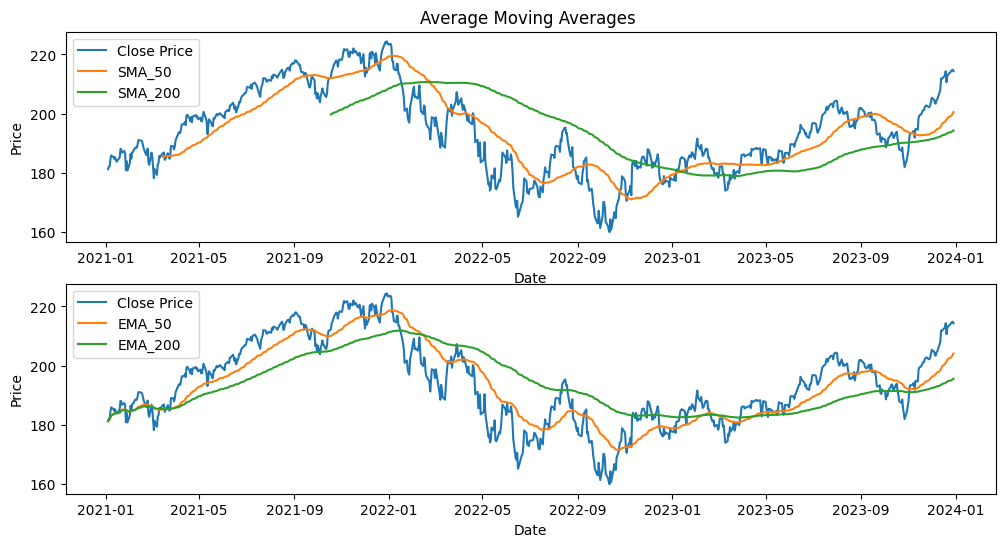

In [ ]:
temp_df = pd.DataFrame(index=data_frames[0].index)
temp_df['average_sma_50'] = 0
temp_df['average_ema_50'] = 0
temp_df['average_sma_200'] = 0
temp_df['average_ema_200'] = 0
temp_df['average_close'] = 0
for i, df in enumerate(data_frames):
    # Calculating Moving Averages
    df['sma_50'] = df['Close'].rolling(window=50).mean()
    df['ema_50'] = df['Close'].ewm(span=50, adjust=True).mean()

    df['sma_200'] = df['Close'].rolling(window=200).mean()
    df['ema_200'] = df['Close'].ewm(span=200, adjust=True).mean()
    
    # Adding to the average
    temp_df['average_sma_50'] += df['sma_50']
    temp_df['average_ema_50'] += df['ema_50']
    temp_df['average_sma_200'] += df['sma_200']
    temp_df['average_ema_200'] += df['ema_200']
    temp_df['average_close'] += df['Close']

    # Plotting
    # plt.figure(figsize=(12,3))
    # plt.plot(df['Close'], label='Close Price')
    # plt.plot(df['sma'], label='SMA')
    # plt.plot(df['ema'], label='EMA')
    # plt.title(f"{stock_details_df['Company Name'][i]} Moving Averages")
    # plt.xlabel('Date')
    # plt.ylabel('Price')
    # plt.legend()

    # # Display the plot
    # plt.show()
    # plt.close()
    
# Plotting the Average moving averages
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(temp_df['average_close']/num_companies, label='Close Price')
plt.plot(temp_df['average_sma_50']/num_companies, label='SMA_50')
plt.plot(temp_df['average_sma_200']/num_companies, label='SMA_200')

plt.title(f"Average Moving Averages ")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.subplot(2,1,2)
plt.plot(temp_df['average_close']/num_companies, label='Close Price')
plt.plot(temp_df['average_ema_50']/num_companies, label='EMA_50')
plt.plot(temp_df['average_ema_200']/num_companies, label='EMA_200')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()
plt.close()
del temp_df


### **2. RSI(Relative Strength Index)**
Indicates if a stock is likely **overbought(Costly than actual value)** or **oversold(cheaper than actual value)**.

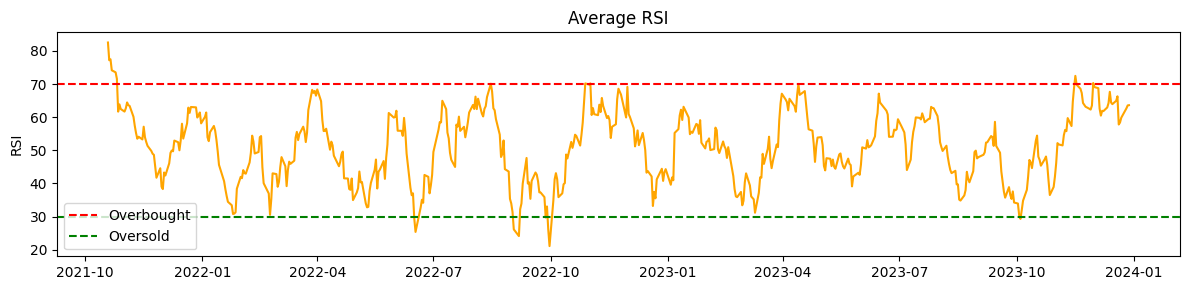

In [ ]:
# Calculating RSI

avg_rsi_df = pd.DataFrame(index=data_frames[0].index)
avg_rsi_df['average_rsi'] = 0
for i,df in enumerate(data_frames):
# Calculate price differences (delta)
    temp_df = pd.DataFrame()
    temp_df['delta'] = df['Close'].diff()

    # Separate gains (positive changes) and losses (negative changes)
    temp_df['gain'] = temp_df['delta'].apply(lambda x: x if x > 0 else 0)
    temp_df['loss'] = temp_df['delta'].apply(lambda x: -x if x < 0 else 0)

    # Calculate smoothed average gain (AG) and smoothed average loss (AL) over 14 periods
    window_length = 14
    temp_df['avg_gain'] = temp_df['gain'].rolling(window=window_length, min_periods=1).mean()
    temp_df['avg_loss'] = temp_df['loss'].rolling(window=window_length, min_periods=1).mean()

    # Calculate RS (Relative Strength)
    temp_df['RS'] = temp_df['avg_gain'] / temp_df['avg_loss']

    # Calculate RSI using the formula
    df['rsi'] = 100 - (100 / (1 + temp_df['RS']))
    avg_rsi_df['average_rsi'] += df['rsi']


    # Plotting
    # plt.figure(figsize=(12,3))


    # plt.plot(df.index, df['rsi'], label='RSI', color='orange')
    # plt.axhline(y=70, color='r', linestyle='--', label='Overbought')
    # plt.axhline(y=30, color='g', linestyle='--', label='Oversold')
    # plt.ylabel('RSI')
    # plt.legend()
    # plt.title(f"{stock_details_df['Company Name'][i]} RSI")
    # plt.tight_layout()
    # plt.show()
    # plt.close()

# PLotting Average RSI
plt.figure(figsize=(12,3))
plt.plot(df.index,avg_rsi_df['average_rsi']/num_companies,color='orange')
plt.axhline(y=70, color='r', linestyle='--', label='Overbought')
plt.axhline(y=30, color='g', linestyle='--', label='Oversold')
plt.ylabel('RSI')
plt.legend()
plt.title("Average RSI")

plt.tight_layout()
plt.show()
plt.close()
del temp_df

# pd.set_option('display.max_rows', None)
# data_frames[0].reset_index(drop=False, inplace=True)
# data_frames[0]


### **3. MACD (Moving Average Convergence Divergence )**
Helps spot changes in trends and gives buy/sell signals when the MACD Line crosses the Signal Line.

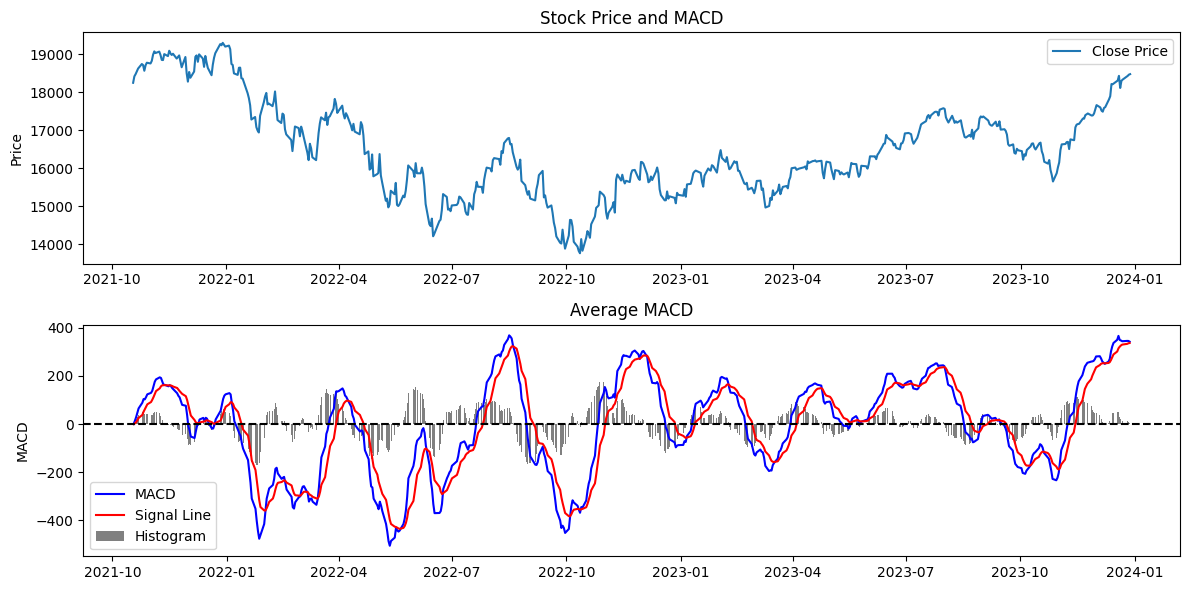

DatetimeIndex(['2021-10-18', '2021-10-19', '2021-10-20', '2021-10-21',
               '2021-10-22', '2021-10-25', '2021-10-26', '2021-10-27',
               '2021-10-28', '2021-10-29',
               ...
               '2023-12-14', '2023-12-15', '2023-12-18', '2023-12-19',
               '2023-12-20', '2023-12-21', '2023-12-22', '2023-12-26',
               '2023-12-27', '2023-12-28'],
              dtype='datetime64[ns]', name='Date', length=553, freq=None)

In [ ]:
# Calculating MACD
temp_df = pd.DataFrame(index=data_frames[0].index)
temp_df['avg_close'] = 0
temp_df['avg_macd'] = 0
temp_df['avg_signal'] = 0
temp_df['avg_macd_histogram'] = 0
for i,df in enumerate(data_frames):
    
    # Calculate the Short-Term EMA (12 periods)
    short_ema = df['Close'].ewm(span=12, adjust=False).mean()

    # Calculate the Long-Term EMA (26 periods)
    long_ema = df['Close'].ewm(span=26, adjust=False).mean()

    # Calculate the MACD line
    df['macd'] = short_ema - long_ema

    # Calculate the Signal line (9 periods EMA of MACD line)
    df['signal'] = df['macd'].ewm(span=9, adjust=False).mean()

    # Calculate the MACD Histogram
    df['macd_histogram'] = df['macd'] - df['signal']

    temp_df['avg_close'] += df['Close']
    temp_df['avg_macd'] += df['macd']
    temp_df['avg_signal'] += df['signal']
    temp_df['avg_macd_histogram'] += df['macd_histogram']

    # plt.figure(figsize=(12,3))
    # plt.plot(df.index, df['macd'], label='MACD', color='blue')
    # plt.plot(df.index, df['signal'], label='Signal Line', color='red')
    # plt.bar(df.index, df['macd_histogram'], label='Histogram', color='gray')
    # plt.axhline(y=0, color='black', linestyle='--')
    # plt.ylabel('MACD')
    # plt.legend()
    # plt.title(f"{stock_details_df['Company Name'][i]} MACD")
    # plt.tight_layout()
    # plt.show()
    # plt.close()
# Plotting Average MACD
plt.figure(figsize=(12,6))

# Price and MACD
plt.subplot(2, 1, 1)
plt.plot(df.index, temp_df['avg_close'], label='Close Price')
plt.title('Stock Price and MACD')
plt.ylabel('Price')
plt.legend()

# MACD and Signal Line
plt.subplot(2, 1, 2)
plt.plot(df.index, temp_df['avg_macd'], label='MACD', color='blue')
plt.plot(df.index, temp_df['avg_signal'], label='Signal Line', color='red')
plt.bar(df.index, temp_df['avg_macd_histogram'], label='Histogram', color='gray')

plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('MACD')
plt.legend()
plt.title('Average MACD')
plt.tight_layout()
plt.show()
plt.close()
# data_frames[0]
df.index


### **4. Adding Target Column**

In [ ]:
for df in data_frames:
    # Create target column for next day's closing price
    df['Next_Day_Close'] = df['Close'].shift(-1)
    df['Next_Day_rsi'] = df['rsi'].shift(-1)
    df['Next_Day_macd_histogram'] = df['macd_histogram'].shift(-1)
    
    # Drop rows with NaN values created by shifting
    df.dropna(inplace=True)
pd.set_option('display.max_columns', None)  # Show all columns


# Assuming data_frames is already loaded and contains your DataFrame
display(data_frames[0])


,Open,High,Low,Close,Adj Close,Volume,sma_50,ema_50,sma_200,ema_200,rsi,macd,signal,macd_histogram,Next_Day_Close,Next_Day_rsi,Next_Day_macd_histogram
Date,,,,,,,,,,,,,,,,,
2021-10-18,143.449997,146.839996,143.160004,146.550003,144.303223,85589200,147.055599,144.838269,135.632100,139.659128,62.159346,-0.861577,-1.421607,0.560030,148.759995,64.555727,0.827646
2021-10-19,147.009995,149.169998,146.550003,148.759995,146.479309,76378900,147.108999,144.992112,135.728850,139.763694,64.555727,-0.387049,-1.214695,0.827646,149.259995,69.856728,0.994980
2021-10-20,148.699997,149.750000,148.119995,149.259995,146.971649,58418800,147.182199,145.159532,135.820100,139.872636,69.856728,0.029029,-0.965950,0.994980,149.479996,68.350384,1.070549
2021-10-21,148.809998,149.639999,147.869995,149.479996,147.188278,61421000,147.254599,145.329012,135.934500,139.982685,68.350384,0.372236,-0.698313,1.070549,148.690002,80.050415,1.017745
2021-10-22,149.690002,150.179993,148.639999,148.690002,146.410400,58883400,147.250599,145.460853,136.023350,140.082274,80.050415,0.573868,-0.443877,1.017745,148.639999,76.950661,0.932152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,196.100006,197.080002,193.500000,194.679993,194.168518,46482500,185.141001,188.006891,178.434050,177.380290,57.388274,2.963181,3.386783,-0.423602,193.600006,59.246142,-0.600373
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.091385,37122800,185.398801,188.226229,178.649100,177.541771,59.246142,2.636317,3.236689,-0.600373,193.050003,49.031934,-0.744305
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.542831,28919300,185.682801,188.415396,178.871851,177.696167,49.031934,2.306308,3.050613,-0.744305,193.149994,52.291513,-0.816932


## **Exporting Data**

### **1. Exporting individual dataframes as csv files for each company**

In [ ]:
for i,df in enumerate(data_frames):
    df.set_index(df.index, inplace=True)
    df.dropna(inplace=True)
    df.to_csv("Stock_Data/"+tickers[i]+".csv")


### **2. Exporting combined dataframe as csv**

In [ ]:
combined_df = pd.concat(data_frames)

# Ensure the 'Date' column is of datetime type
combined_df.index = pd.to_datetime(combined_df.index)

# Save the combined DataFrame to a CSV file
combined_df.to_csv('combined_stock_data.csv')


In [ ]:
# Record the end time
end_time = time.time()

# Convert the runtime to a more readable format (seconds)
print(f"Total runtime: {end_time - start_time:.2f} seconds")


Total runtime: 37.85 seconds
